In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib import rcParams
import seaborn as sns
from textwrap import wrap
from tqdm import tqdm
import pandas as pd
import re
import math
import gc
import json

In [21]:
def read_tensors_aux(dir, pt_name_predicate=None):
    """ recursively read tensors from a directory """
    if pt_name_predicate is None:
        pt_name_predicate = lambda x, y: True
    tensors = {}
    for path in os.listdir(dir):
        if path.endswith('.pt'):
            key = path[:-3]
            if pt_name_predicate is None or pt_name_predicate(key, dir):
                try:
                    tensors[key] = torch.load(os.path.join(dir, path))
                except Exception as e:
                    print(f"Error loading {path}: {e}")
        elif os.path.isdir(os.path.join(dir, path)):
            key = path.split('_')[1] if path.startswith('timestep_') else path 
            tensors[key] = read_tensors_aux(os.path.join(dir, path), pt_name_predicate)
        else:
            print(f"Skipping {path}, not a tensor or directory")
    return tensors

In [420]:
dirname = 'outputs/slurm/slurm/g8_sa01_aa1_lr3e-4'
with open(f'{dirname}/logs/training_log_group.log', 'r') as f:
    logs = f.read().replace("'", '"').replace('nan', 'null')
    logs = logs.replace('tensor(', '').replace(', device="cuda:0", grad_fn=<NegBackward0>)', '').replace(', device="cuda:0", grad_fn=<MeanBackward0>)', '').replace('.,', '.0,')
    logs = logs.splitlines()
    logs = [json.loads(line) for line in logs if line.strip()]

In [421]:
logs[0].keys()

dict_keys(['epoch', 't', 'prompt_idx', 'seed_idx', 'ref_reward', 'rewards', 'advantages', 'normalized_advantages', 'normalized_rewards', 'logps', 'kld', 'logp_entropy', 'loss'])

In [422]:
G = max(len(logs[i]['logps']) for i in range(len(logs)))
G

8

In [423]:
data = []
for i, log in enumerate(logs):
    for key in ['rewards', 'normalized_rewards', 'advantages', 'normalized_advantages','logps']:
        for g in range(G):
            if key in log:
                data.append({
                    'log_idx': i,
                    'epoch': log['epoch'],
                    't': log['t'],
                    'prompt_idx': log['prompt_idx'],
                    'seed_idx': log['seed_idx'],
                    'G_idx': g,
                    'metric': key,
                    'value': log[key][g]
                })
    data.append({
        'log_idx': i,
        'epoch': log['epoch'],
        't': log['t'],
        'prompt_idx': log['prompt_idx'],
        'seed_idx': log['seed_idx'],
        'G_idx': None,
        'metric': 'loss',
        'value': log['loss']
    })
    if 'ref_reward' in log:
        data.append({
            'log_idx': i,
            'epoch': log['epoch'],
            't': log['t'],
            'prompt_idx': log['prompt_idx'],
            'seed_idx': log['seed_idx'],
            'G_idx': None,
            'metric': 'rewards',
            'value': log['ref_reward']
        })

df = pd.DataFrame(data)

In [424]:
metrics = df['metric'].unique()
n_metrics = len(metrics)
n_epochs = df['epoch'].nunique()
n_logs = df['log_idx'].nunique()
G = df['G_idx'].nunique()  # exclude None

In [425]:
df.shape

(210, 8)

In [426]:
with open(f'{dirname}/logs/policy_stats.log', 'r') as f:
    policy_logs = f.read().replace("'", '"').replace('nan', 'null').splitlines()
    policy_logs = [json.loads(line) for line in policy_logs if line.strip()]

In [427]:
# parse tag "ep{epoch}_t{t}_p{prompt_idx}_s{seed_idx}_g{g}" to separate fields
for log in policy_logs:
    tag = log['tag']
    m = re.match(r'ep(\d+)_t(\d+)_p(\d+)_s(\d+)_g(\d+)', tag)
    if m:
        log['epoch'] = int(m.group(1))
        log['t'] = int(m.group(2))
        log['prompt_idx'] = int(m.group(3))
        log['seed_idx'] = int(m.group(4))
        log['G_idx'] = int(m.group(5))  
    else:
        log['epoch'] = None
        log['t'] = None
        log['prompt_idx'] = None
        log['seed_idx'] = None
        log['G_idx'] = None
        
    stats_after = log['stats_after']
    stats_before = log['stats_before']
    log['latent_before_min'] = stats_before['min']
    log['latent_before_max'] = stats_before['max']
    log['latent_before_mean'] = stats_before['mean']
    log['latent_before_std'] = stats_before['std']
    log['latent_after_min'] = stats_after['min']
    log['latent_after_max'] = stats_after['max']
    log['latent_after_mean'] = stats_after['mean']
    log['latent_after_std'] = stats_after['std']

In [428]:
policy_df = pd.DataFrame(policy_logs)

In [429]:
policy_df.columns

Index(['tag', 't_idx', 'sigma_t', 'cfg_scale', 'action_norm', 'action_mean',
       'action_std', 'logp', 'stats_before', 'stats_after', 'epoch', 't',
       'prompt_idx', 'seed_idx', 'G_idx', 'latent_before_min',
       'latent_before_max', 'latent_before_mean', 'latent_before_std',
       'latent_after_min', 'latent_after_max', 'latent_after_mean',
       'latent_after_std'],
      dtype='object')

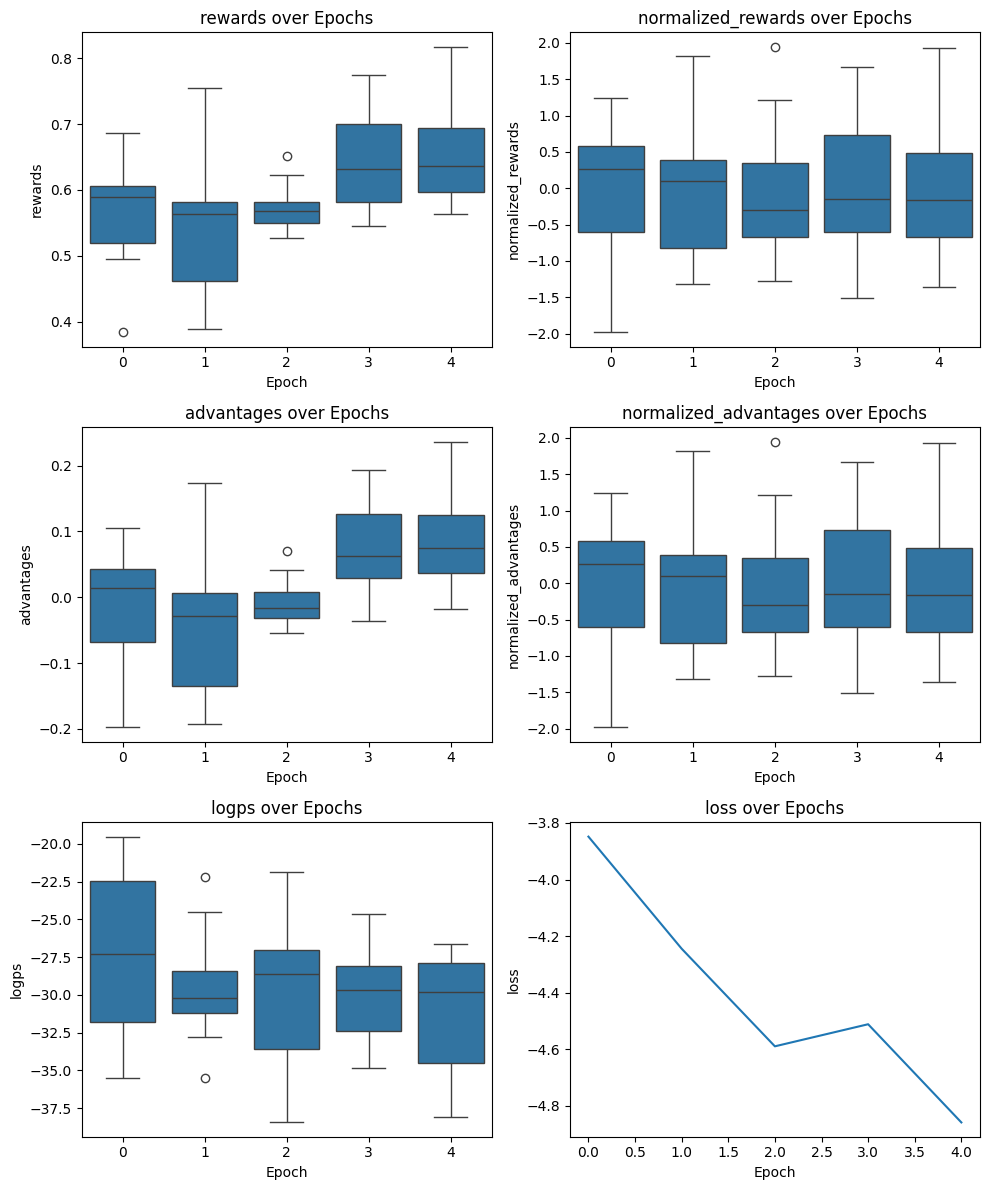

In [431]:
# we have rows with epoch, metric, value. Create a boxplot of value vs epoch for all metrics in a grid
ncols = 2
nrows = math.ceil(n_metrics / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
for i, metric in enumerate(metrics):
    r = i // ncols
    c = i % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    if metric == 'loss':
        sns.lineplot(x='log_idx', y='value', data=df[df['metric'] == metric], ax=ax)
    else:
        sns.boxplot(x='log_idx', y='value', data=df[df['metric'] == metric], ax=ax)
    ax.set_title('\n'.join(wrap(f'{metric} over Epochs', 40)))
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
plt.tight_layout()
plt.show()

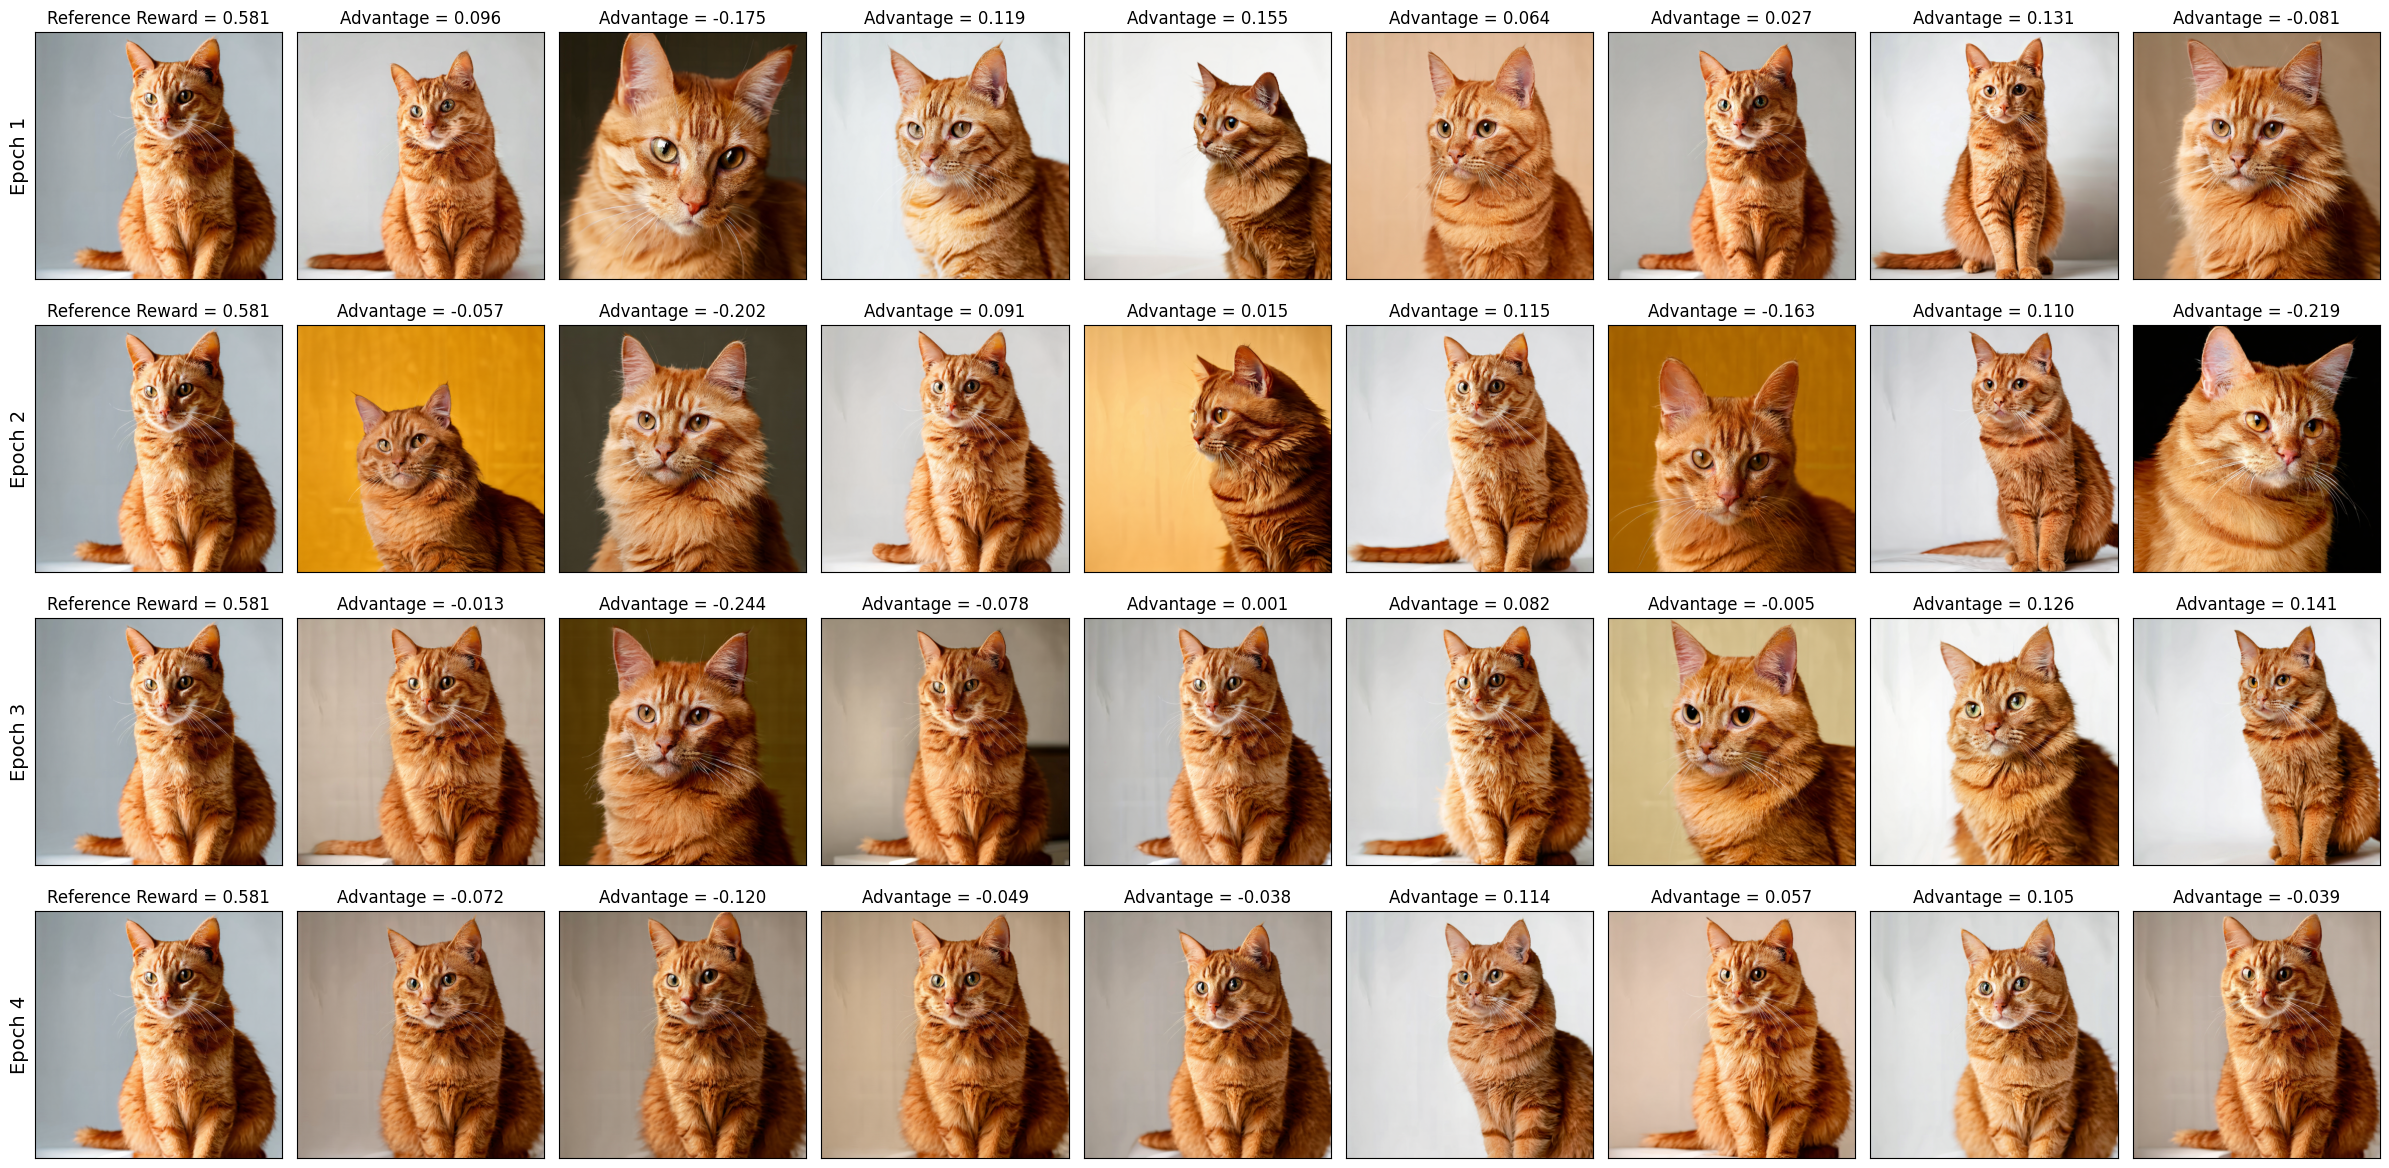

In [375]:
# plot grid of images, epoch rows, G cols. The images are in 'dirname/ep{epoch}_t000_p00_s00_g{G_idx}.png'. For each image, write its reward value from the logs above.
fig, axs = plt.subplots(n_logs, G+1, figsize=(G*3, n_logs*3))
# for epoch in range(1, n_epochs+1):
for log_idx in range(0, n_logs):
    epoch = df[df['log_idx'] == log_idx]['epoch'].values[0]
    t = df[df['log_idx'] == log_idx]['t'].values[0]
    prompt_idx = df[df['log_idx'] == log_idx]['prompt_idx'].values[0]
    seed_idx = df[df['log_idx'] == log_idx]['seed_idx'].values[0]
    image_paths = [ f'{dirname}/imgs/ep{epoch:02d}_t{t:03d}_p{prompt_idx:02d}_s{seed_idx:02d}_ref.png' ] + [ f'{dirname}/imgs/ep{epoch:02d}_t{t:03d}_p{prompt_idx:02d}_s{seed_idx:02d}_g{g:02d}.png' for g in range(0, G) ]
    advantages = [ df[(df['epoch'] == epoch) & (df['log_idx'] == log_idx) & (df['G_idx'] == g) & (df['metric'] == 'advantages')]['value'].values[0] for g in range(0, G) ]
    ref_reward = df[(df['epoch'] == epoch) & (df['log_idx'] == log_idx) & (df['metric'] == 'rewards') & (df['G_idx'].isnull())]['value'].values[0]

    titles = [f'Reference Reward = {ref_reward:.3f}'] + [f'Advantage = {advantages[g]:.3f}' for g in range(0, G)]

    for g in range(0,G+1):
        ax = axs[log_idx, g] if n_logs > 1 else axs[g]
        ax.imshow(plt.imread(image_paths[g]))
        ax.set_title(titles[g])
        ax.set_xticks([])
        ax.set_yticks([])
        if g == 0:
            ax.set_ylabel(f'Epoch {epoch}', fontsize=14)
        else:
            ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [225]:
tensors = read_tensors_aux(f'{dirname}/tensors')

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/slurm/grpo-new/g8_sa005_aa094/tensors'

In [ ]:
tensors['action_ep01_t000_p00_s00_g00'].shape

In [ ]:
# plot grid of images, epoch rows, G cols. The images are in 'dirname/ep{epoch}_t000_p00_s00_g{G_idx}.png'. For each image, write its reward value from the logs above.
fig, axs = plt.subplots(n_epochs, G, figsize=(G*3, n_epochs*3))
for epoch in range(1, n_epochs+1):
    tensor_keys = [ f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}' for g in range(0, G) ]
    for g in range(0,G):
        ax = axs[epoch-1, g] if n_epochs > 1 else axs[g]
        ax.imshow(tensors[tensor_keys[g]].squeeze(0).view(8,8).cpu().numpy(), cmap='viridis')
        ax.set_title(f"mean={float(tensors[tensor_keys[g]].mean().cpu().numpy()):.2f}, std={float(tensors[tensor_keys[g]].std().cpu().numpy()):.2f}")
        ax.set_xticks([])
        ax.set_yticks([])
        if g == 0:
            ax.set_ylabel(f'Epoch {epoch}', fontsize=14)
        else:
            ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
data = []
for epoch in range(1, n_epochs+1):
    for g in range(0, G):
        data.append({
            'epoch': epoch, 
            'G': g, 
            'norm': float(tensors[f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}'].norm()),
            'max': float(tensors[f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}'].max()),
            'min': float(tensors[f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}'].min()),
            'mean': float(tensors[f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}'].mean()),
            'std': float(tensors[f'action_ep{epoch:02d}_t000_p00_s00_g{g:02d}'].std()),         
        })

data = pd.DataFrame(data)

data = data[data['epoch'] <= 14]

In [ ]:
# box plot of value vs epoch
plt.figure(figsize=(8,6))
sns.boxplot(x='epoch', y='std', data=data)
plt.title('Standard Deviation of Action Tensor over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Standard Deviation of Action Tensor')
# logscale
plt.yscale('log')
plt.show()

## Policy logs

In [193]:
policy_logs[0]['stats_after'].keys()

dict_keys(['min', 'max', 'mean', 'std'])

In [196]:
policy_df.columns

Index(['tag', 't_idx', 'sigma_t', 'cfg_scale', 'action_norm', 'action_mean',
       'action_std', 'logp', 'stats_before', 'stats_after', 'epoch', 't',
       'prompt_idx', 'seed_idx', 'latent_before_min', 'latent_before_max',
       'latent_before_mean', 'latent_before_std', 'latent_after_min',
       'latent_after_max', 'latent_after_mean', 'latent_after_std'],
      dtype='object')

In [197]:
policy_df.head()

tag  t_idx  sigma_t  cfg_scale  action_norm  action_mean  \
0  ep01_t000_p00_s00_g00      0      1.0        4.5     1.839941    -0.021115   
1  ep01_t000_p00_s00_g01      0      1.0        4.5     1.861748    -0.024794   
2  ep01_t000_p00_s00_g02      0      1.0        4.5     1.432992    -0.004246   
3  ep01_t000_p00_s00_g03      0      1.0        4.5     1.696954    -0.024301   
4  ep01_t000_p00_s00_g04      0      1.0        4.5     1.654795     0.041419   

   action_std       logp                                       stats_before  \
0    0.230832 -35.507420  {'min': -4.2734375, 'max': 4.45703125, 'mean':...   
1    0.233223 -33.156898  {'min': -4.2734375, 'max': 4.45703125, 'mean':...   
2    0.180489 -21.271423  {'min': -4.2734375, 'max': 4.45703125, 'mean':...   
3    0.212389 -29.263622  {'min': -4.2734375, 'max': 4.45703125, 'mean':...   
4    0.204262 -25.300888  {'min': -4.2734375, 'max': 4.45703125, 'mean':...   

                                         stats_after  ...  prompt_idx  \
0  {'min': -6.0859375, 'max': 6.421875, 'mean': -...  ...           0   
1  {'min': -5.76953125, 'max': 6.44921875, 'mean'...  ...           0   
2  {'min': -5.671875, 'max': 6.14453125, 'mean': ...  ...           0   
3  {'min': -5.9375, 'max': 5.9921875, 'mean': 0.0...  ...           0   
4  {'min': -6.265625, 'max': 6.21484375, 'mean': ...  ...           0   

   seed_idx  latent_before_min  latent_before_max  latent_before_mean  \
0         0          -4.273438           4.457031           -0.000362   
1         0          -4.273438           4.457031           -0.000362   
2         0          -4.273438           4.457031           -0.000362   
3         0          -4.273438           4.457031           -0.000362   
4         0          -4.273438           4.457031           -0.000362   

   latent_before_std  latent_after_min  latent_after_max  latent_after_mean  \
0           0.998535         -6.085938          6.421875          -0.000429   
1           0.998535         -5.769531          6.449219          -0.001203   
2           0.998535         -5.671875          6.144531          -0.000294   
3           0.998535         -5.937500          5.992188           0.000288   
4           0.998535         -6.265625          6.214844           0.000127   

   latent_after_std  
0          1.368164  
1          1.368164  
2          1.372070  
3          1.371094  
4          1.371094  

[5 rows x 22 columns]

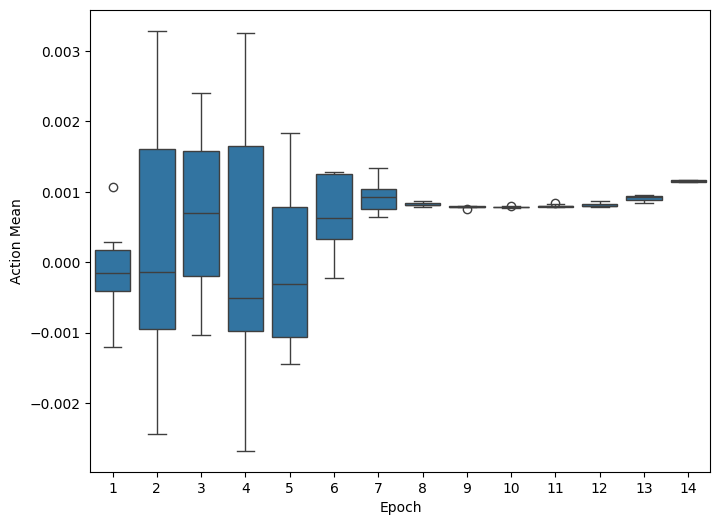

In [204]:
# box plot of action_norm vs epoch
plt.figure(figsize=(8,6))
sns.boxplot(x='epoch', y='latent_after_mean', data=policy_df)
plt.xlabel('Epoch')
plt.ylabel('Action Mean')
plt.show()

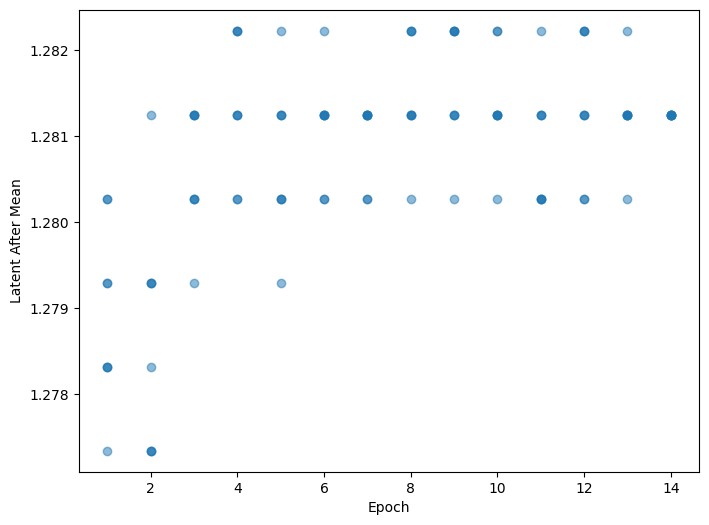

In [166]:
tmp = policy_df[policy_df['latent_after_std'] <= 1.35]
plt.figure(figsize=(8,6))
# scatter plot of latent_after_mean vs epoch
plt.scatter(tmp['epoch'], tmp['latent_after_std'], alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Latent After Mean')
plt.show()

In [68]:
policy_df[policy_df['epoch'] == 5][['epoch', 'G_idx', 'logp']]

epoch  G_idx         logp
32      5      0  6328.652344
33      5      1 -3648.172119
34      5      2 -2450.472656
35      5      3 -2908.210449
36      5      4 -4917.710938
37      5      5  1979.154053
38      5      6 -1762.732666
39      5      7  7220.064941